In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Commonly used modules
import numpy as np
import os
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import IPython
from six.moves import urllib

print(tf.__version__)

2.5.0


In [3]:
df1 = pd.read_csv("https://raw.githubusercontent.com/VivaswatS/selCoefEst/main/traindata/trip-2021-07-28.csv")


# (train_features, train_labels), (test_features, test_labels) = keras.datasets.boston_housing.load_data()

# # get per-feature statistics (mean, standard deviation) from the training set to normalize by
# train_mean = np.mean(train_features, axis=0)
# train_std = np.std(train_features, axis=0)
# train_features = (train_features - train_mean) / train_std

In [ ]:
test_labels.shape

(102,)

In [4]:
dat = df1.to_numpy()
gamma = np.unique(dat[:,1])
idx = [np.where(dat[:,1] == gamma[i]) for i in np.arange(len(gamma))]

In [45]:
from sklearn.model_selection import train_test_split
# create an 80/20 split in each data set
temp = [train_test_split(dat[idx[i][0],0], dat[idx[i][0],2], test_size=0.15, random_state=42) for i in np.arange(len(gamma))]

# for each gamma value...
Xltrain = []
Xltest = []
altrain = []
altest = []
for t in np.arange(len(temp)):
    Xltrain.append(temp[t][0])
    Xltest.append(temp[t][1])
    altrain.append(temp[t][2])
    altest.append(temp[t][3])

In [46]:
train_data = np.vstack((np.hstack(Xltrain[0:50]), np.repeat(gamma[0:50], len(Xltrain[0])))).T
train_labs = np.hstack(altrain[0:50])

In [47]:
test_data = np.vstack((np.hstack(Xltest[0:50]), np.repeat(gamma[0:50], len(Xltest[0])))).T
test_labs = np.hstack(altest[0:50])

In [49]:
test_labs.shape

(7500,)

### Build the model

Building the neural network requires configuring the layers of the model, then compiling the model. First we stack a few layers together using `keras.Sequential`. Next we configure the loss function, optimizer, and metrics to monitor. These are added during the model's compile step:

* *Loss function* - measures how accurate the model is during training, we want to minimize this with the optimizer.
* *Optimizer* - how the model is updated based on the data it sees and its loss function.
* *Metrics* - used to monitor the training and testing steps.

Let's build a network with 1 hidden layer of 20 neurons, and use mean squared error (MSE) as the loss function (most common one for regression problems):

In [9]:
def build_model():
    model = keras.Sequential([
        Dense(50, activation=tf.nn.relu, input_shape=[len(train_data[0])]),
        Dense(10, activation=tf.nn.relu, input_shape=[50]),
        Dense(1)
    ])

    model.compile(optimizer=tf.optimizers.Adam(), 
                  loss='mse',
                  metrics=['mae', 'mse'])
    return model

### Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model—in this example, the `train_features` and `train_labels` arrays.
2. The model learns to associate features and labels.
3. We ask the model to make predictions about a test set—in this example, the `test_features` array. We verify that the predictions match the labels from the `test_labels` array. 

To start training,  call the `model.fit` method—the model is "fit" to the training data:

In [50]:
# this helps makes our output less verbose but still shows progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
history = model.fit(train_data, train_labs, epochs=5000, verbose=0, validation_split=0.1,
                    callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


....................................................................................................
....................................................................................................
..........

In [51]:
rmse_final = np.sqrt(float(hist['val_mse'].tail(1)))
print()
print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_final, 3)))


Final Root Mean Square Error on validation set: 3529.089


Now, let's plot the loss function measure on the training and validation sets. The validation set is used to prevent overfitting ([learn more about it here](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)). However, because our network is small, the training convergence without noticeably overfitting the data as the plot shows.

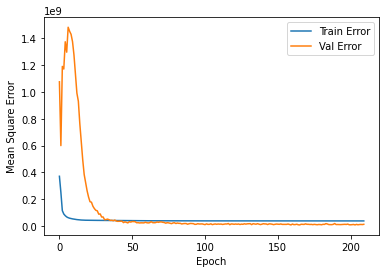

In [52]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.legend()

plot_history()

In [53]:
hist

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,370763616.0,14863.909180,370763616.0,1.075655e+09,28849.699219,1.075655e+09,0
1,251639632.0,11827.777344,251639632.0,5.997156e+08,22972.375000,5.997156e+08,1
2,114386136.0,8466.154297,114386136.0,1.190438e+09,32858.335938,1.190438e+09,2
3,89348368.0,7877.039062,89348368.0,1.171110e+09,32409.916016,1.171110e+09,3
4,76845456.0,7228.020508,76845456.0,1.374351e+09,34564.476562,1.374351e+09,4
...,...,...,...,...,...,...,...
205,37749324.0,4499.615234,37749324.0,8.981642e+06,2625.384033,8.981642e+06,205
206,37747700.0,4498.729492,37747700.0,1.076339e+07,2871.332764,1.076339e+07,206
207,37749668.0,4497.118652,37749668.0,1.148475e+07,2966.138916,1.148475e+07,207
208,37741776.0,4497.487305,37741776.0,1.057514e+07,2847.397949,1.057514e+07,208


Next, compare how the model performs on the test dataset:

In [ ]:
#test_features_norm = (test_data - train_mean) / train_std
mse, _, _ = model.evaluate(test_data, test_labs)
rmse = np.sqrt(mse)
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))

7/7 [==============================] - 0s 2ms/step - loss: 19176.2168 - mae: 119.0167 - mse: 19176.2168
Root Mean Square Error on test set: 138.478


In [54]:
preds = model.predict(test_data)
#test_data.shape

In [55]:
np.corrcoef(np.ravel(test_labs), np.ravel(preds))[0,1]

0.8811527580956667

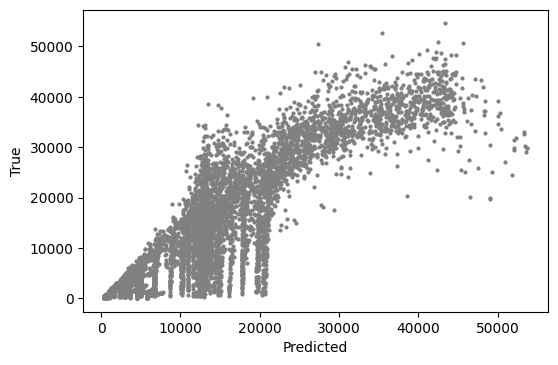

In [60]:
plt.figure(dpi=100)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.plot(np.ravel(preds), np.ravel(test_labs), 'o',  color="grey", markersize=2)

## Acknowledgements

The contents of this tutorial is based on and inspired by the work of [TensorFlow team](https://www.tensorflow.org) (see their [Colab notebooks](https://www.tensorflow.org/tutorials/)), our [MIT Human-Centered AI team](https://hcai.mit.edu), and individual pieces referenced in the [MIT Deep Learning](https://deeplearning.mit.edu) course slides.